In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent / "src"))

from collections import Counter, defaultdict
from typing import Dict, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch

from neural_decoder.neural_decoder_trainer import get_dataset_loaders
from neural_decoder.phoneme_utils import id_to_phone


In [2]:
def count_strings(strings: list) -> Dict[int, str]:
    sentence_counts = Counter(strings)

    count_dict = defaultdict(list)
    for sentence, count in sentence_counts.items():
        count_dict[count].append(sentence)

    return dict(count_dict)


## Load and extract data

In [ ]:
root_dir =  Path.cwd().parent
dataset_path = root_dir.parent.parent / "willett2023" / "competitionData" / "ptDecoder_ctc"

_, _, loaded_data = get_dataset_loaders(
    dataset_path,
    batch_size=1,
)

In [4]:
sentences = []
words = []
phonemes = []
brain_signals = []

for sample in loaded_data["train"]:
    for t in sample['transcriptions']:
        sentences.append(t)
        for word in t.split(" "):
            word = word.replace(",", "").replace(".", "").replace("?", "").replace("!", "").lower()
            words.append(word)

    for p in sample['phonemes']:
        first_zero_index = np.where(p == 0)[0][0]
        unpadded = p[:first_zero_index]

        for idx in unpadded:
            phonemes.append(id_to_phone(idx - 1))
    
    for s in sample['sentenceDat']:
        brain_signals.append(s)


## Compute trainings set statistics

In [5]:
unique_sentences = list(set(sentences))
count2sentences = count_strings(sentences)

unique_words = list(set(words))
count2words = count_strings(words)

unique_phonemes = list(set(phonemes))
count2phonemes = count_strings(phonemes)

print("\nTraining set statistics:\n")
print(f"Total number of sentences:  {len(sentences)}")
print(f"Number of unique sentences: {len(list(set(sentences)))}")
print(f"Total number of words:      {len(words)}")
print(f"Number of unique words:     {len(list(set(words)))}")
print(f"Total number of phonemes:   {len(phonemes)}")
print(f"Number of unique phonemes:  {len(list(set(phonemes)))}")

print(f"\nAverage number of phonemes per sentence: {len(phonemes) / len(sentences):.1f}")
print(f"Average number of words per sentence:     {len(words) / len(sentences):.1f}\n")


Training set statistics:

Total number of sentences:  8800
Number of unique sentences: 8709
Total number of words:      55629
Number of unique words:     6593
Total number of phonemes:   247305
Number of unique phonemes:  40

Average number of phonemes per sentence: 28.1
Average number of words per sentence:     6.3



In [6]:
def plot_occurrences(
        count_dict: dict,
        title: str,
        x_label: str,
        y_label: str ,
        y_log_scale: bool = True,
        x_log_scale: bool = False, 
        keys_on_y_axis: bool = False,
        figsize: Tuple[int, int] = (10, 6),
        save_to: str = None,
):
    x = []
    y = []
    if keys_on_y_axis:
        value2count = {}
        for count, value in count_dict.items():
            for v in value:
                value2count[v] = count
        
        for val, count in sorted(value2count.items()):
            x.append(val)
            y.append(count)
    else:
        counts = sorted(count_dict.keys())
        num_words = [len(count_dict[count]) for count in counts]
        x = list(range(1, max(counts) + 1))

        y = [num_words[counts.index(y)] if y in counts else 0 for y in x]

    plt.figure(figsize=figsize)
    plt.bar(x, y, color='navy', alpha=0.5, edgecolor='black')

    if y_log_scale:
        plt.yscale('log')
    if x_log_scale:
        plt.xscale('log')

    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)

    if len(x) < 50:
        plt.xticks(ticks=x)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    if save_to is not None:
        plt.savefig(save_to)
    plt.show()


In [7]:
plot_dir = root_dir / "plots" / "data_visualization"

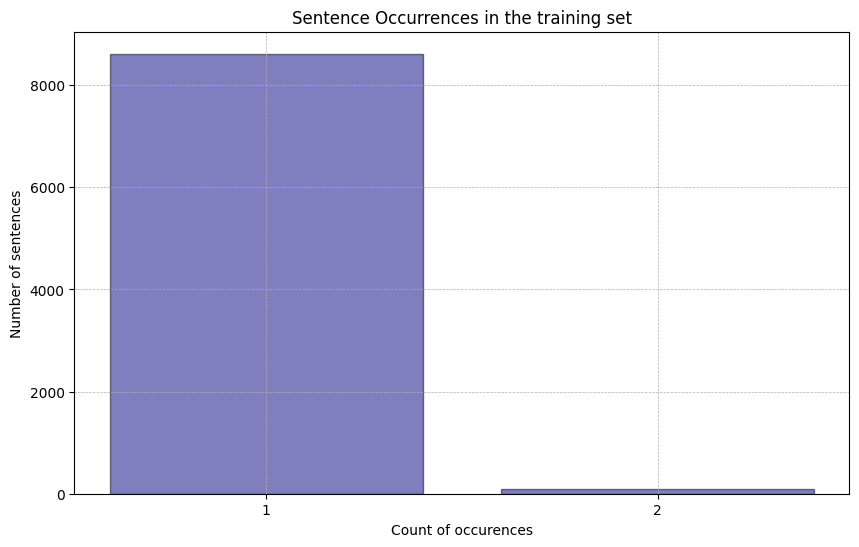

In [8]:
plot_occurrences(
    count2sentences, 
    title="Sentence Occurrences in the training set", 
    x_label="Count of occurences", 
    y_label="Number of sentences", 
    y_log_scale=False,
    # keys_on_y_axis=True, 
    save_to=plot_dir / "viz_sentence_occurences.png"
)

In [9]:
# plot_occurrences(
#     count2words, 
#     title="Word Occurrences in the training set", 
#     x_label="Words", 
#     y_label="Count of occurences in the training set", 
#     x_log_scale=False, 
#     y_log_scale=False, 
#     figsize=(15,7),
#     keys_on_y_axis=True, 
# )

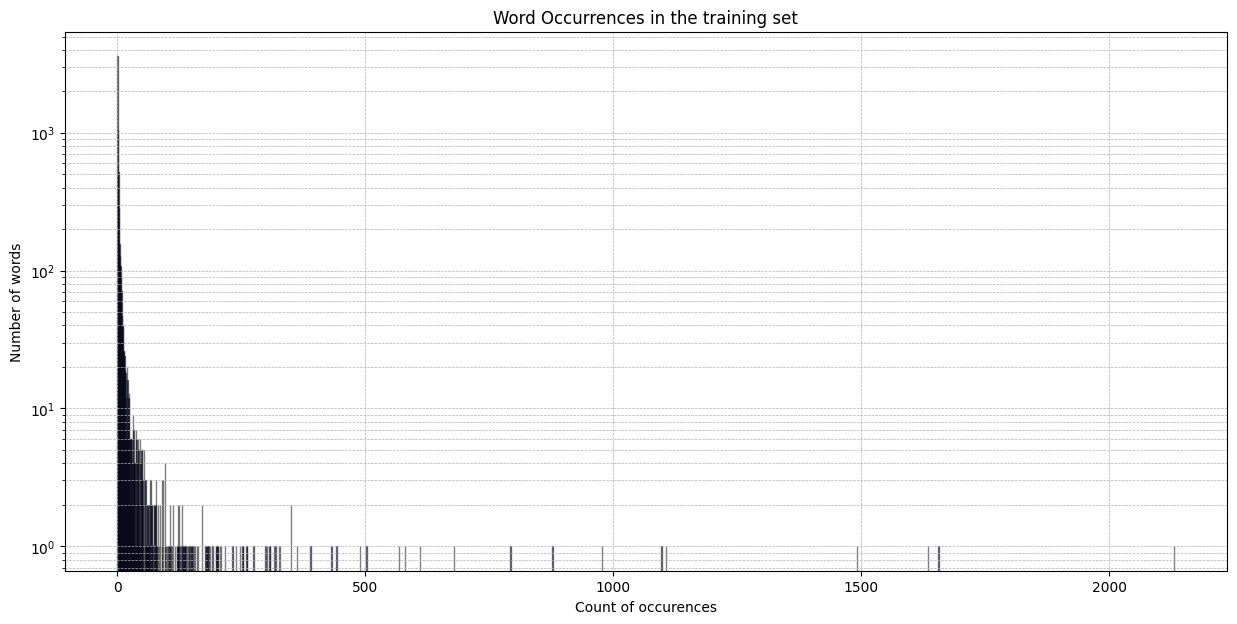

In [10]:
plot_occurrences(
    count2words, 
    title="Word Occurrences in the training set", 
    x_label="Count of occurences", 
    y_label="Number of words", 
    x_log_scale=False, 
    figsize=(15,7),
    save_to=plot_dir / "viz_word_occurences.png"
)

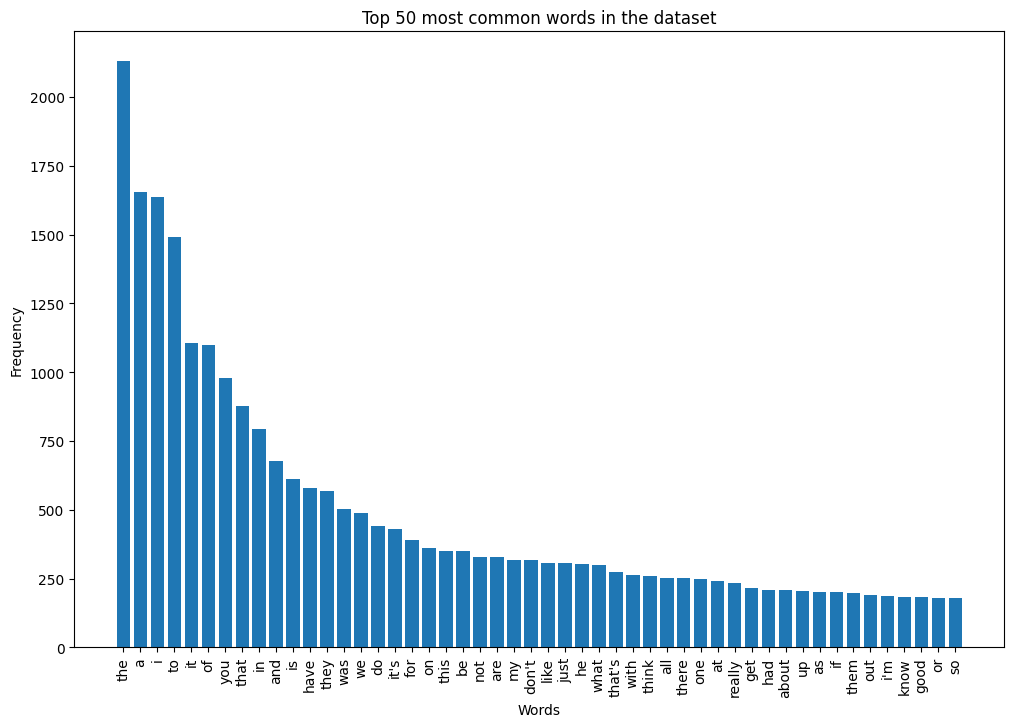

In [18]:
import pandas as pd
from collections import Counter
import re

word_counts = Counter()
for sentence in sentences:
    words_ = sentence.lower().replace(",", "").replace(".", "").replace("!", "").replace("?", "").split(" ")
    word_counts.update(words_)

df = pd.DataFrame(word_counts.items(), columns=['word', 'frequency'])
df = df.sort_values(by='frequency', ascending=False)

top_n = 50
df = df.head(top_n)

plt.figure(figsize=(12, 8))
plt.bar(df['word'], df['frequency'])
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 50 most common words in the dataset')
plt.xticks(rotation=90) 
plt.savefig(plot_dir / "viz_top_50_common_words.png")
plt.show()


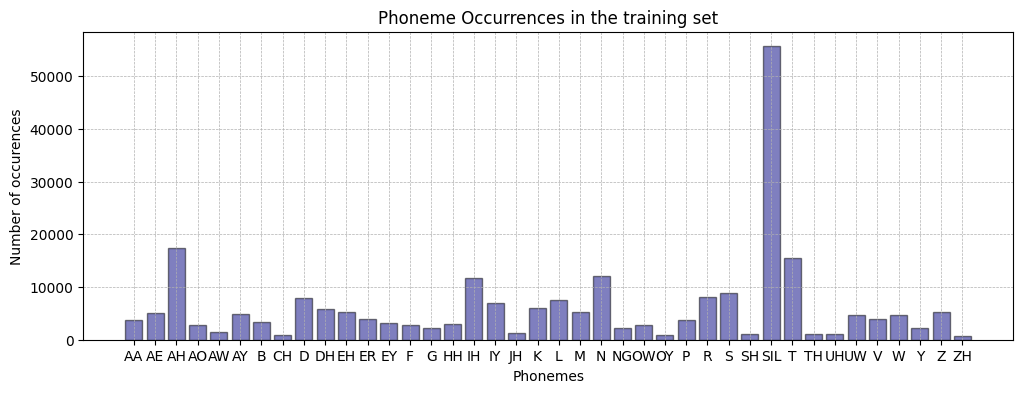

In [12]:
plot_occurrences(
    count2phonemes, 
    title="Phoneme Occurrences in the training set", 
    x_label="Phonemes", 
    y_label="Number of occurences", 
    y_log_scale=False, 
    keys_on_y_axis=True, 
    figsize=(12, 4),
    save_to=plot_dir / "viz_phonemes_occurences.png"
)

In [13]:
print(min(count2phonemes.keys()))

678


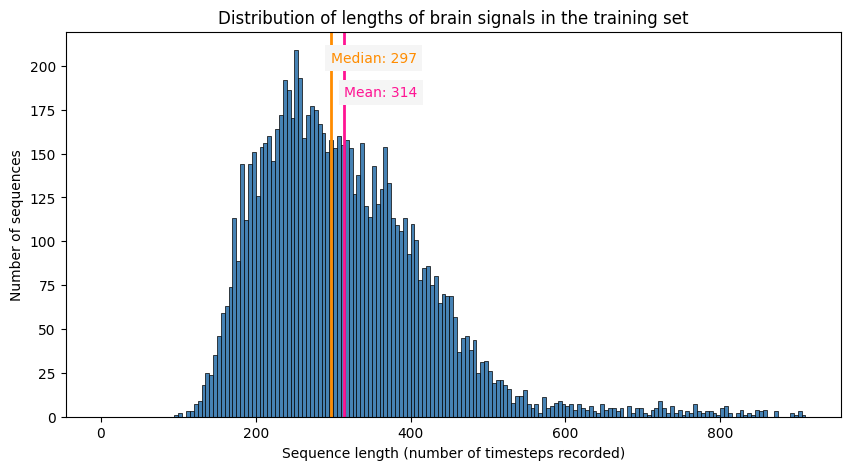

In [15]:
from statistics import mean, median

lengths = [s.shape[0] for s in brain_signals]

bins = np.arange(0, max(lengths) + 5, 5)
bin_counts, bin_edges = np.histogram(lengths, bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

plt.figure(figsize=(10, 5))
plt.bar(bin_centers, bin_counts, width=5, edgecolor='black', linewidth=.5, color='steelblue')
plt.xlabel('Sequence length (number of timesteps recorded)')
plt.ylabel('Number of sequences')
plt.title('Distribution of lengths of brain signals in the training set')

mean_len = mean(lengths)
median_len = median(lengths)

plt.axvline(mean_len, color='deeppink', linestyle='solid', linewidth=2)
plt.axvline(median_len, color='darkorange', linestyle='solid', linewidth=2)

plt.text(mean_len, plt.ylim()[1] * 0.86, f'Mean: {int(mean_len)}', color='deeppink', ha='left', va='top',
         bbox=dict(facecolor='whitesmoke', alpha=1., edgecolor='none'))
plt.text(median_len, plt.ylim()[1] * 0.95, f'Median: {int(median_len)}', color='darkorange', ha='left', va='top',
         bbox=dict(facecolor='whitesmoke', alpha=1., edgecolor='none'))

plt.savefig(plot_dir / "viz_brain_signal_lengths.png")
plt.show()